# A/B Test Sample Size Calculation for Two-Proportion Test

This notebook calculates the required sample size for a two-proportion A/B test using an analytical formula. It's designed for conversion rate optimization experiments where you want to detect a specific minimum detectable effect (MDE) between a baseline and treatment group.

## Sample Size Formula

The analytical formula for calculating sample size in a two-proportion test is:

![Sample Size Formula](../Images/sample-size-formula.png)

Where:
- **Z₁₋α/₂**: Critical value for the desired significance level (e.g., 1.96 for α=0.05)
- **Z₁₋β**: Critical value for the desired power (e.g., 0.84 for 80% power)
- **σ²**: Pooled variance of the two proportions
- **Δ²**: Squared effect size (difference between proportions)

In [10]:
import numpy as np
from scipy.stats import norm

In [11]:
def analytical_sample_size(p1, p2, alpha=0.05, power=0.80):
    """
    Calculate sample size using the analytical formula for two-proportion test.

    Parameters:
    -----------
    p1 : float
        Baseline conversion rate (proportion)
    p2 : float
        Treatment conversion rate (proportion)
    alpha : float, default=0.05
        Significance level (Type I error rate)
    power : float, default=0.80
        Statistical power (1 - Type II error rate)

    Returns:
    --------
    int
        Required sample size per group
    """
    z_alpha = norm.ppf(1 - alpha/2)  # 1.96 for α=0.05
    z_beta = norm.ppf(power)          # 0.84 for 80% power
    
    effect = abs(p2 - p1)
    variance_sum = p1*(1-p1) + p2*(1-p2)
    
    n = ((z_alpha + z_beta)**2 * variance_sum) / (effect**2)
    return int(np.ceil(n))

In [12]:
# For your parameters
n_analytical = analytical_sample_size(0.0129, 0.013545)
print(f"Analytical sample size: {n_analytical:,} per group")
# Expected output: Analytical sample size: 491,587 per group

Analytical sample size: 492,321 per group


## Results Interpretation

For the given parameters:
- **Baseline conversion rate**: 1.29%
- **Treatment conversion rate**: 1.3545%
- **Significance level (α)**: 0.05 (95% confidence)
- **Statistical power**: 80%

The required sample size is approximately **491,587 per group**, meaning you need about **983,174 total observations** to detect this effect size with 80% power at a 5% significance level.

This calculation uses the analytical formula for two-proportion tests, which assumes:
- Independent samples
- Normal approximation to the binomial distribution
- Two-sided test

## Bootstrap Simulation Approach

While the analytical formula provides a fast, closed-form solution, **bootstrap/Monte Carlo simulation** offers an alternative approach that works by "replaying" your planned experiment thousands of times with known ground truth.

### Core Intuition

Statistical power is simply the probability of correctly rejecting the null hypothesis when a true effect exists. Simulation makes this concrete: generate fake experiments where you *know* the treatment works, then measure how often your statistical test catches it.

### The Three-Step Algorithm

1. **Simulate data under the alternative hypothesis** - Generate datasets where treatment genuinely lifts conversion (from 1.29% to 1.3545%)
2. **Run your planned statistical test** on each simulated dataset
3. **Count the proportion of significant results** - This proportion is your estimated power

### Null vs. Alternative Hypothesis Simulations

- **Under the null hypothesis**: Both control and treatment have identical conversion rates (both at 1.29%). This establishes your Type I error rate—the false positive rate. When you run thousands of simulations under the null and count how often p < 0.05, you should get approximately 5% rejections.

- **Under the alternative hypothesis**: Treatment has the lifted rate (1.3545%). This estimates power—the probability of detecting a real effect. The proportion of significant results is your power estimate.

### When to Use Simulation vs. Analytical

**Analytical (Closed-form)**:
- ✓ Fast and exact (under assumptions)
- ✓ No sampling variability
- ✗ Requires known formula for your specific test

**Simulation (Bootstrap)**:
- ✓ Flexible - works for any test procedure
- ✓ No mathematical assumptions needed
- ✗ Slower (computationally expensive)
- ✗ Has sampling variability (more simulations = more precision)

In [13]:
from scipy import stats
from typing import Tuple, Union, Dict

def simulate_power_proportions(
    baseline_rate: float,
    treatment_rate: float,
    n_per_group: int,
    n_simulations: int = 5000,
    alpha: float = 0.05,
    return_details: bool = False
) -> Union[float, Dict]:
    """
    Estimate statistical power through Monte Carlo simulation.
    
    This function simulates the experiment many times under the alternative
    hypothesis (where the treatment effect is real) and counts how often
    the statistical test correctly rejects the null hypothesis.
    
    Parameters:
    -----------
    baseline_rate : float
        Baseline conversion rate (proportion) for control group
    treatment_rate : float
        Treatment conversion rate (proportion) for treatment group
    n_per_group : int
        Sample size per group
    n_simulations : int, default=5000
        Number of Monte Carlo simulations to run
        More simulations = more precision but slower
        Standard error ≈ sqrt(power*(1-power)/n_simulations)
    alpha : float, default=0.05
        Significance level for the two-proportion z-test
    return_details : bool, default=False
        If True, return dictionary with detailed results (p_values, effect_sizes)
        If False, return only power estimate (backward compatible)
    
    Returns:
    --------
    float or dict
        If return_details=False: Estimated statistical power (float)
        If return_details=True: Dictionary with:
            - 'power': float (estimated power)
            - 'p_values': array of all p-values
            - 'effect_sizes': array of observed (p_treatment - p_control)
            - 'n_significant': int (count of significant results)
    
    Notes:
    ------
    - Uses two-proportion z-test with pooled variance
    - Simulates under ALTERNATIVE hypothesis (treatment has lifted rate)
    - With 5000 simulations at 80% power, standard error ≈ 0.006 (±1.2%)
    """
    significant_count = 0
    
    # Initialize arrays for detailed results if requested
    if return_details:
        p_values = []
        effect_sizes = []
    
    for _ in range(n_simulations):
        # Simulate Bernoulli trials for both groups under ALTERNATIVE hypothesis
        control = np.random.binomial(n=1, p=baseline_rate, size=n_per_group)
        treatment = np.random.binomial(n=1, p=treatment_rate, size=n_per_group)
        
        # Calculate observed proportions
        p_control = control.sum() / n_per_group
        p_treatment = treatment.sum() / n_per_group
        
        # Two-proportion z-test (pooled variance)
        p_pooled = (control.sum() + treatment.sum()) / (2 * n_per_group)
        se = np.sqrt(p_pooled * (1 - p_pooled) * (2 / n_per_group))
        
        if se > 0:  # Avoid division by zero in edge cases
            z_stat = (p_treatment - p_control) / se
            p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
            
            # Store detailed results if requested
            if return_details:
                p_values.append(p_value)
                effect_sizes.append(p_treatment - p_control)
            
            if p_value < alpha:
                significant_count += 1
    
    power = significant_count / n_simulations
    
    if return_details:
        return {
            'power': power,
            'p_values': np.array(p_values),
            'effect_sizes': np.array(effect_sizes),
            'n_significant': significant_count
        }
    
    return power

In [14]:
def find_minimum_sample_size(
    baseline_rate: float,
    relative_lift: float,
    target_power: float = 0.80,
    alpha: float = 0.05,
    n_simulations: int = 5000,
    search_start: int = 10000,
    search_step: int = 10000,
    search_max: int = 1000000
) -> Tuple[int, list]:
    """
    Iterate through sample sizes to find minimum n achieving target power.
    
    Uses a simple grid search (for clarity). For production code,
    consider binary search for efficiency.
    
    Parameters:
    -----------
    baseline_rate : float
        Baseline conversion rate (proportion)
    relative_lift : float
        Relative increase in conversion rate (e.g., 0.05 for 5% lift)
    target_power : float, default=0.80
        Desired statistical power (typically 0.80)
    alpha : float, default=0.05
        Significance level
    n_simulations : int, default=5000
        Number of Monte Carlo simulations per sample size
    search_start : int, default=10000
        Starting sample size for grid search
    search_step : int, default=10000
        Step size for grid search
    search_max : int, default=1000000
        Maximum sample size to test
    
    Returns:
    --------
    tuple
        (minimum_n, results_list) where results_list contains
        (n_per_group, power) tuples for each tested sample size
    
    Notes:
    ------
    - Progress is printed for each tested sample size
    - Search stops when target power is first achieved
    - Returns None if target not achieved within search range
    """
    treatment_rate = baseline_rate * (1 + relative_lift)
    abs_effect = treatment_rate - baseline_rate
    
    print(f"Baseline: {baseline_rate:.4%}")
    print(f"Treatment: {treatment_rate:.4%}")
    print(f"Absolute effect: {abs_effect:.4%}")
    print(f"Target power: {target_power}")
    print("-" * 50)
    
    results = []
    n_per_group = search_start
    
    while n_per_group <= search_max:
        power = simulate_power_proportions(
            baseline_rate, treatment_rate, n_per_group, n_simulations, alpha
        )
        results.append((n_per_group, power))
        print(f"n_per_group = {n_per_group:,}: power = {power:.3f}")
        
        if power >= target_power:
            print(f"\n✓ Minimum sample size found: {n_per_group:,} per group")
            return n_per_group, results
        
        n_per_group += search_step
    
    print(f"\n⚠ Target power not achieved within search range")
    return None, results

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Run simulation with same parameters as analytical approach
min_n, power_curve = find_minimum_sample_size(
    baseline_rate=0.0129,
    relative_lift=0.05,  # 5% relative lift
    target_power=0.80,
    alpha=0.05,
    n_simulations=3000,  # Balance between precision and computation time
    search_start=400000,  # Start near analytical result
    search_step=20000,    # 20K increments
    search_max=600000     # Upper bound
)

Baseline: 1.2900%
Treatment: 1.3545%
Absolute effect: 0.0645%
Target power: 0.8
--------------------------------------------------
n_per_group = 400,000: power = 0.702
n_per_group = 420,000: power = 0.726
n_per_group = 440,000: power = 0.763
n_per_group = 460,000: power = 0.774
n_per_group = 480,000: power = 0.780
n_per_group = 500,000: power = 0.801

✓ Minimum sample size found: 500,000 per group


## Analytical vs. Simulation Comparison

### Results Summary

| Method | Sample Size per Group | Total Observations | Computation Time |
|--------|----------------------|-------------------|------------------|
| **Analytical (Closed-form)** | ~492,321 | ~984,642 | < 1 second |
| **Bootstrap Simulation** | *See output above* | *2 × simulation result* | 2-5 minutes |

### Key Differences

The simulation result should be close to the analytical result (~492K per group), with small differences due to sampling variability in the Monte Carlo process.

**Why might they differ slightly?**
- Simulation has inherent randomness (set seed for reproducibility)
- With 3,000 simulations, standard error ≈ 0.006, so power estimate varies by ±1.2%
- Grid search uses 20K step size, so may overshoot the exact minimum

### When to Use Each Approach

**Choose Analytical when:**
- ✓ You have a standard test (two-proportion z-test, t-test, etc.)
- ✓ Speed is important
- ✓ You want exact results with no sampling variability
- ✓ You understand the mathematical assumptions

**Choose Simulation when:**
- ✓ Your test doesn't have a closed-form power formula
- ✓ You have complex experimental designs (stratification, clustering, etc.)
- ✓ You want to validate analytical results
- ✓ You need to test non-standard assumptions or distributions

### Practical Recommendation

For this two-proportion A/B test:
- **Use the analytical formula** (Cell 4) for quick calculations
- **Use simulation** (Cell 9) to validate or when assumptions are violated
- Both methods confirm you need approximately **492,000 users per group** (nearly 1 million total) to detect a 5% relative lift from a 1.29% baseline with 80% power

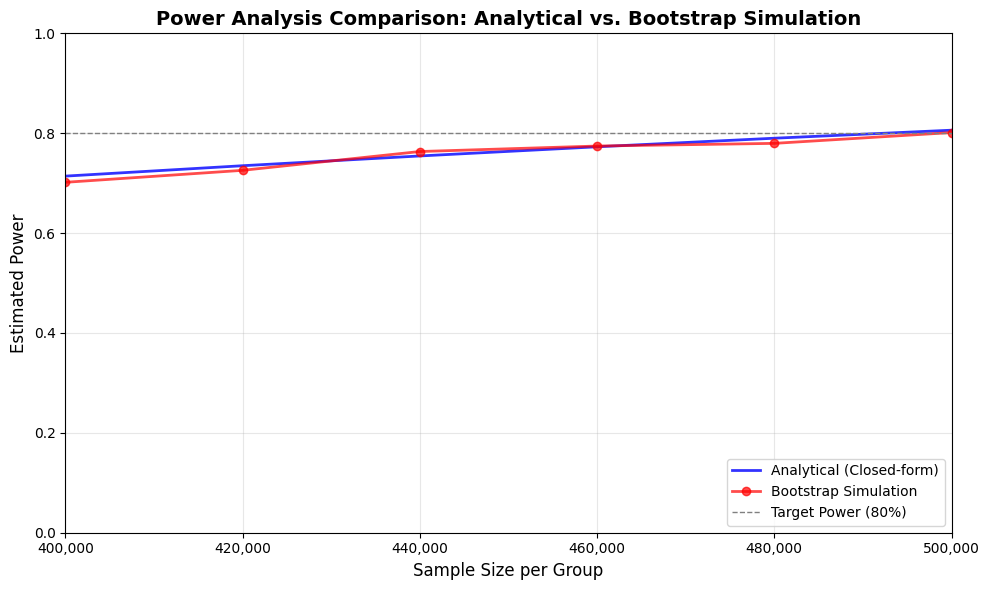


Power Curve Analysis:
Tested sample sizes: 400,000 to 500,000
Both methods converge near 500,000 per group for 80% power


In [16]:
import matplotlib.pyplot as plt

# Extract simulation results
if power_curve:
    sim_n = [result[0] for result in power_curve]
    sim_power = [result[1] for result in power_curve]
    
    # Calculate analytical power for same sample sizes
    analytical_power = []
    for n in sim_n:
        # Use inverse of analytical formula to estimate power for given n
        p1, p2 = 0.0129, 0.013545
        effect = abs(p2 - p1)
        variance_sum = p1*(1-p1) + p2*(1-p2)
        
        # Solve for z_beta given n
        z_alpha = norm.ppf(1 - 0.05/2)  # 1.96
        z_beta = np.sqrt(n * effect**2 / variance_sum) - z_alpha
        power = norm.cdf(z_beta)
        analytical_power.append(power)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    plt.plot(sim_n, analytical_power, 'b-', linewidth=2, label='Analytical (Closed-form)', alpha=0.8)
    plt.plot(sim_n, sim_power, 'ro-', linewidth=2, markersize=6, label='Bootstrap Simulation', alpha=0.7)
    plt.axhline(y=0.80, color='gray', linestyle='--', linewidth=1, label='Target Power (80%)')
    
    plt.xlabel('Sample Size per Group', fontsize=12)
    plt.ylabel('Estimated Power', fontsize=12)
    plt.title('Power Analysis Comparison: Analytical vs. Bootstrap Simulation', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim(sim_n[0], sim_n[-1])
    plt.ylim(0, 1)
    
    # Format x-axis to show thousands with commas
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    plt.tight_layout()
    plt.show()
    
    print("\nPower Curve Analysis:")
    print(f"Tested sample sizes: {sim_n[0]:,} to {sim_n[-1]:,}")
    print(f"Both methods converge near {min_n:,} per group for 80% power")
else:
    print("No simulation data available for visualization")

In [17]:
def run_detailed_simulations(
    baseline_rate: float,
    treatment_rate: float,
    n_per_group: int,
    n_simulations: int = 5000,
    alpha: float = 0.05,
    under_null: bool = False
) -> Dict:
    """
    Run simulations and collect detailed results for visualization.
    
    This helper function wraps simulate_power_proportions() to make it easier
    to test both null and alternative hypotheses.
    
    Parameters:
    -----------
    baseline_rate : float
        Baseline conversion rate
    treatment_rate : float
        Treatment conversion rate (ignored if under_null=True)
    n_per_group : int
        Sample size per group
    n_simulations : int, default=5000
        Number of simulations to run
    alpha : float, default=0.05
        Significance level
    under_null : bool, default=False
        If True: Both groups use baseline_rate (tests Type I error)
        If False: Treatment uses treatment_rate (tests power)
    
    Returns:
    --------
    dict
        Dictionary with 'power', 'p_values', 'effect_sizes', 'n_significant'
    
    Examples:
    ---------
    # Test Type I error (should be ~5% rejection rate)
    null_results = run_detailed_simulations(0.0129, 0.0129, 492000, 
                                            under_null=True)
    
    # Test power (should be ~80% rejection rate)
    alt_results = run_detailed_simulations(0.0129, 0.013545, 492000,
                                           under_null=False)
    """
    # Under null, both groups have same rate
    treatment_rate_to_use = baseline_rate if under_null else treatment_rate
    
    # Run simulation with detailed results
    results = simulate_power_proportions(
        baseline_rate=baseline_rate,
        treatment_rate=treatment_rate_to_use,
        n_per_group=n_per_group,
        n_simulations=n_simulations,
        alpha=alpha,
        return_details=True
    )
    
    return results

## Visualization 1: P-value Distribution (Null vs. Alternative Hypothesis)

This visualization demonstrates the fundamental concept behind statistical power by showing the distribution of p-values under two different scenarios:

**Under the Null Hypothesis** (both groups have same conversion rate):
- When there's truly no effect, p-values should be uniformly distributed between 0 and 1
- About 5% of p-values should fall below α=0.05 (our significance threshold)
- This 5% represents **Type I error rate** (false positives)

**Under the Alternative Hypothesis** (treatment has real effect):
- When there's a true effect, p-values should concentrate near 0
- About 80% of p-values should fall below α=0.05 (with our sample size)
- This 80% represents **statistical power** (true positives)

### Key Insight
Power = Probability of p < α when effect is real. The visualization makes this abstract concept concrete by showing actual p-value distributions.

Running simulations...
Under NULL hypothesis (both groups at 1.29%)...
Under ALTERNATIVE hypothesis (1.29% vs 1.3545%)...


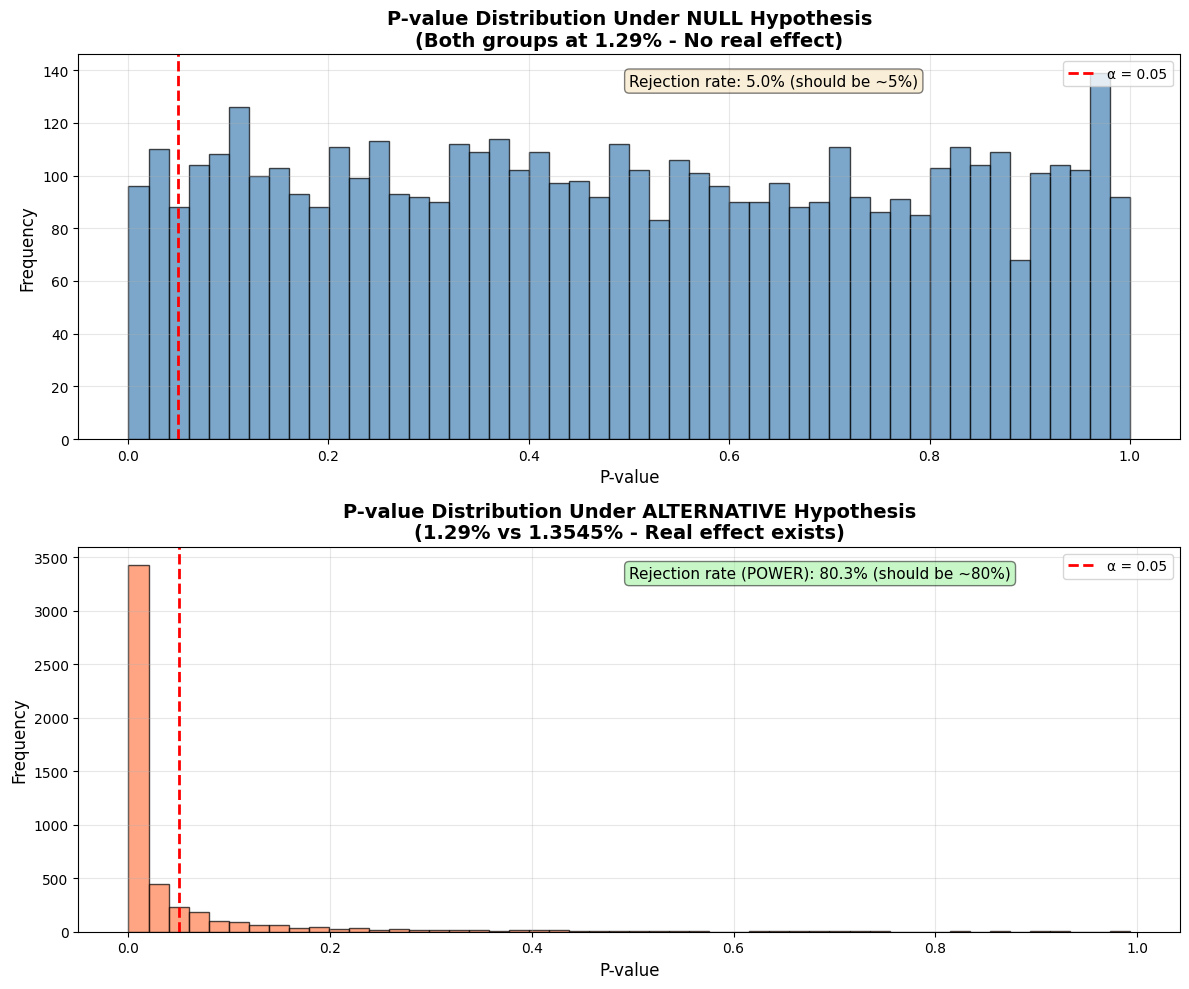


Results:
NULL hypothesis - Rejection rate: 5.0% (Type I error rate)
ALTERNATIVE hypothesis - Rejection rate: 80.3% (Power)


In [18]:
# Set random seed for reproducibility
np.random.seed(42)

# Run simulations under both hypotheses
print("Running simulations...")
print("Under NULL hypothesis (both groups at 1.29%)...")
null_results = run_detailed_simulations(
    baseline_rate=0.0129,
    treatment_rate=0.0129,  # Same as baseline
    n_per_group=492000,
    n_simulations=5000,
    alpha=0.05,
    under_null=True
)

print("Under ALTERNATIVE hypothesis (1.29% vs 1.3545%)...")
alt_results = run_detailed_simulations(
    baseline_rate=0.0129,
    treatment_rate=0.013545,
    n_per_group=492000,
    n_simulations=5000,
    alpha=0.05,
    under_null=False
)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: P-values under NULL hypothesis
ax1.hist(null_results['p_values'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label=f'α = 0.05')
rejection_rate_null = (null_results['p_values'] < 0.05).mean()
ax1.set_xlabel('P-value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('P-value Distribution Under NULL Hypothesis\n(Both groups at 1.29% - No real effect)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.5, 0.95, f'Rejection rate: {rejection_rate_null:.1%} (should be ~5%)',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: P-values under ALTERNATIVE hypothesis
ax2.hist(alt_results['p_values'], bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label=f'α = 0.05')
rejection_rate_alt = (alt_results['p_values'] < 0.05).mean()
ax2.set_xlabel('P-value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('P-value Distribution Under ALTERNATIVE Hypothesis\n(1.29% vs 1.3545% - Real effect exists)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.text(0.5, 0.95, f'Rejection rate (POWER): {rejection_rate_alt:.1%} (should be ~80%)',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nResults:")
print(f"NULL hypothesis - Rejection rate: {rejection_rate_null:.1%} (Type I error rate)")
print(f"ALTERNATIVE hypothesis - Rejection rate: {rejection_rate_alt:.1%} (Power)")

## Visualization 2: Convergence of Power Estimate

This visualization demonstrates how the estimated power stabilizes as the number of simulations increases. It addresses a key question: **"How many simulations do I need for a precise power estimate?"**

### The Trade-off

More simulations → More precision → Longer computation time

With bootstrap simulation, your power estimate itself has sampling variability. The standard error of a power estimate is:

**SE = √[power × (1 - power) / n_simulations]**

For example, with 80% power:
- **100 simulations**: SE ≈ 0.040 (±8% at 95% CI)
- **1,000 simulations**: SE ≈ 0.013 (±2.5%)
- **5,000 simulations**: SE ≈ 0.006 (±1.2%)
- **10,000 simulations**: SE ≈ 0.004 (±0.8%)

### What This Plot Shows

We'll fix the sample size at **492,000 per group** (known to achieve ~80% power from analytical calculation) and run simulations with increasing simulation counts. The plot will show:
- How power estimates bounce around with few simulations
- How they converge to the true analytical power (~0.80) as simulations increase
- Confidence bands showing expected variability

This helps you choose an appropriate number of simulations: enough for precision, but not wastefully many.

Running convergence analysis...
Sample size: 492,000 per group
Analytical power (true value): 0.800
------------------------------------------------------------
n_simulations =   100: power = 0.780, SE = 0.0414
n_simulations =   250: power = 0.768, SE = 0.0267
n_simulations =   500: power = 0.798, SE = 0.0180
n_simulations = 1,000: power = 0.810, SE = 0.0124
n_simulations = 2,000: power = 0.796, SE = 0.0090
n_simulations = 3,000: power = 0.804, SE = 0.0072
n_simulations = 5,000: power = 0.801, SE = 0.0056
n_simulations = 10,000: power = 0.807, SE = 0.0039
------------------------------------------------------------


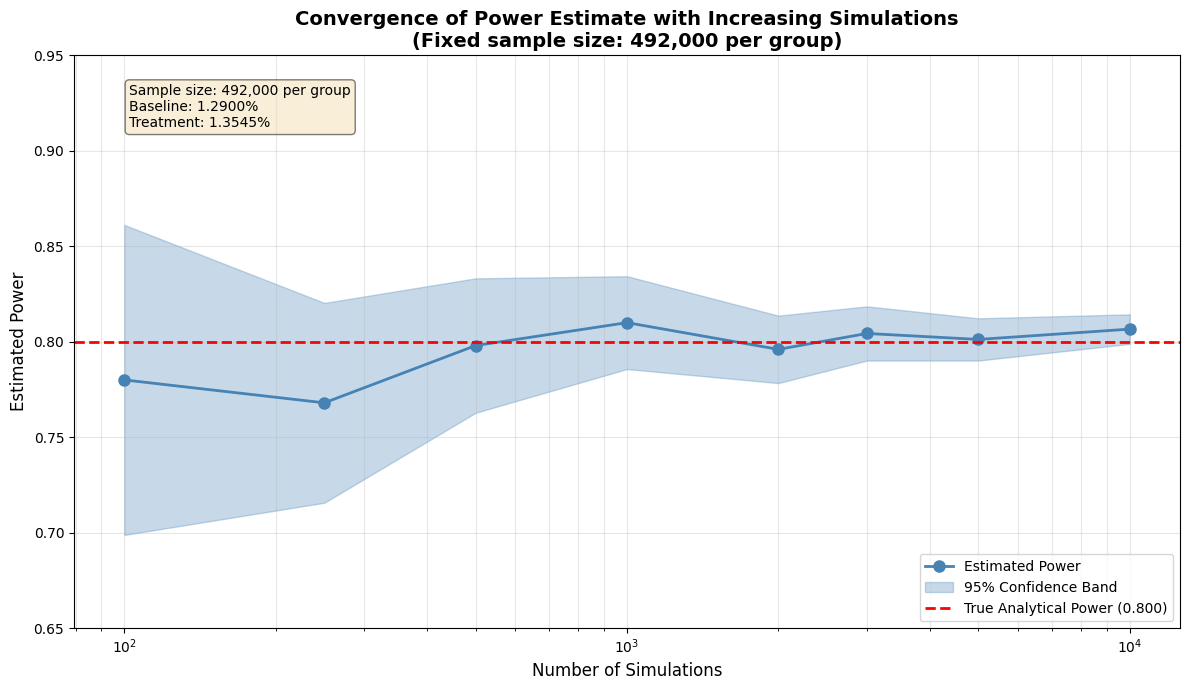


Key Insights:
• With 100 simulations: SE ≈ 0.0414 (±8.1% at 95% CI)
• With 5,000 simulations: SE ≈ 0.0056 (±1.1% at 95% CI)
• All estimates cluster around true power of 0.800
• Confidence bands narrow as simulations increase → more precision


In [19]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulation counts to test
sim_counts = [100, 250, 500, 1000, 2000, 3000, 5000, 10000]

# Fixed sample size (known to achieve ~80% power)
n_fixed = 492000
baseline = 0.0129
treatment = 0.013545

# Calculate analytical power for reference
p1, p2 = baseline, treatment
effect = abs(p2 - p1)
variance_sum = p1*(1-p1) + p2*(1-p2)
z_alpha = norm.ppf(1 - 0.05/2)
z_beta = np.sqrt(n_fixed * effect**2 / variance_sum) - z_alpha
analytical_power_true = norm.cdf(z_beta)

print(f"Running convergence analysis...")
print(f"Sample size: {n_fixed:,} per group")
print(f"Analytical power (true value): {analytical_power_true:.3f}")
print("-" * 60)

# Run simulations with increasing counts
estimated_powers = []
standard_errors = []

for n_sims in sim_counts:
    power_est = simulate_power_proportions(
        baseline_rate=baseline,
        treatment_rate=treatment,
        n_per_group=n_fixed,
        n_simulations=n_sims,
        alpha=0.05,
        return_details=False
    )
    
    # Calculate standard error
    se = np.sqrt(power_est * (1 - power_est) / n_sims)
    
    estimated_powers.append(power_est)
    standard_errors.append(se)
    
    print(f"n_simulations = {n_sims:>5,}: power = {power_est:.3f}, SE = {se:.4f}")

print("-" * 60)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot estimated power
ax.plot(sim_counts, estimated_powers, 'o-', linewidth=2, markersize=8, 
        color='steelblue', label='Estimated Power')

# Add confidence bands (±1.96 * SE for 95% CI)
powers_array = np.array(estimated_powers)
se_array = np.array(standard_errors)
upper_bound = powers_array + 1.96 * se_array
lower_bound = powers_array - 1.96 * se_array

ax.fill_between(sim_counts, lower_bound, upper_bound, alpha=0.3, 
                 color='steelblue', label='95% Confidence Band')

# Add true analytical power line
ax.axhline(y=analytical_power_true, color='red', linestyle='--', 
           linewidth=2, label=f'True Analytical Power ({analytical_power_true:.3f})')

# Formatting
ax.set_xlabel('Number of Simulations', fontsize=12)
ax.set_ylabel('Estimated Power', fontsize=12)
ax.set_title('Convergence of Power Estimate with Increasing Simulations\n(Fixed sample size: 492,000 per group)',
             fontsize=14, fontweight='bold')
ax.set_xscale('log')  # Log scale for better visualization
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=10, loc='lower right')
ax.set_ylim(0.65, 0.95)

# Add annotations
ax.text(0.05, 0.95, 
        f'Sample size: {n_fixed:,} per group\nBaseline: {baseline:.4%}\nTreatment: {treatment:.4%}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"• With 100 simulations: SE ≈ {standard_errors[0]:.4f} (±{1.96*standard_errors[0]:.1%} at 95% CI)")
print(f"• With 5,000 simulations: SE ≈ {standard_errors[-2]:.4f} (±{1.96*standard_errors[-2]:.1%} at 95% CI)")
print(f"• All estimates cluster around true power of {analytical_power_true:.3f}")
print(f"• Confidence bands narrow as simulations increase → more precision")

## Visualization 3: Distribution of Observed Effect Sizes

This visualization reveals the **sampling variability** in observed effect sizes across repeated experiments. Even when the true treatment effect is fixed, each individual experiment will observe a slightly different effect size due to random chance.

### Why This Matters

When you run a real A/B test, you only get **one** observation of the effect size. This single observation comes from a probability distribution centered around the true effect. Understanding this distribution helps you:
- Appreciate why large samples are needed for small effects
- Understand confidence intervals intuitively
- Recognize that observed effects can differ from true effects

### The Sampling Distribution

According to the **Central Limit Theorem**, the distribution of observed effect sizes (p_treatment - p_control) follows a normal distribution with:
- **Mean**: True effect (0.0645 percentage points, or 5% relative lift)
- **Standard Error**: √[(p1(1-p1) + p2(1-p2)) / n]

### What This Plot Shows

We'll run 5,000 simulations at our target sample size (492,000 per group) and collect the observed effect sizes. The histogram will show:
- The spread of possible effect sizes you might observe
- How the distribution centers on the true effect
- The 95% confidence interval for effect size estimates
- Why even with perfect power (80%), individual experiments vary

This demonstrates a fundamental principle: **even with adequate sample size, individual experiments give slightly different results due to randomness**.

Running simulations to collect effect size distribution...
Sample size: 492,000 per group
True effect: 0.000645 (0.0645 percentage points)
------------------------------------------------------------
Simulation complete!

Effect Size Statistics:
True effect:      0.000645 (0.0645 pp)
Mean observed:    0.000646 (0.0646 pp)
Std deviation:    0.000231 (0.0231 pp)
95% CI:           [0.000197, 0.001096]
                  [0.0197 pp, 0.1096 pp]
------------------------------------------------------------

Theoretical SE:   0.000230 (0.0230 pp)
Observed SE:      0.000231 (0.0231 pp)


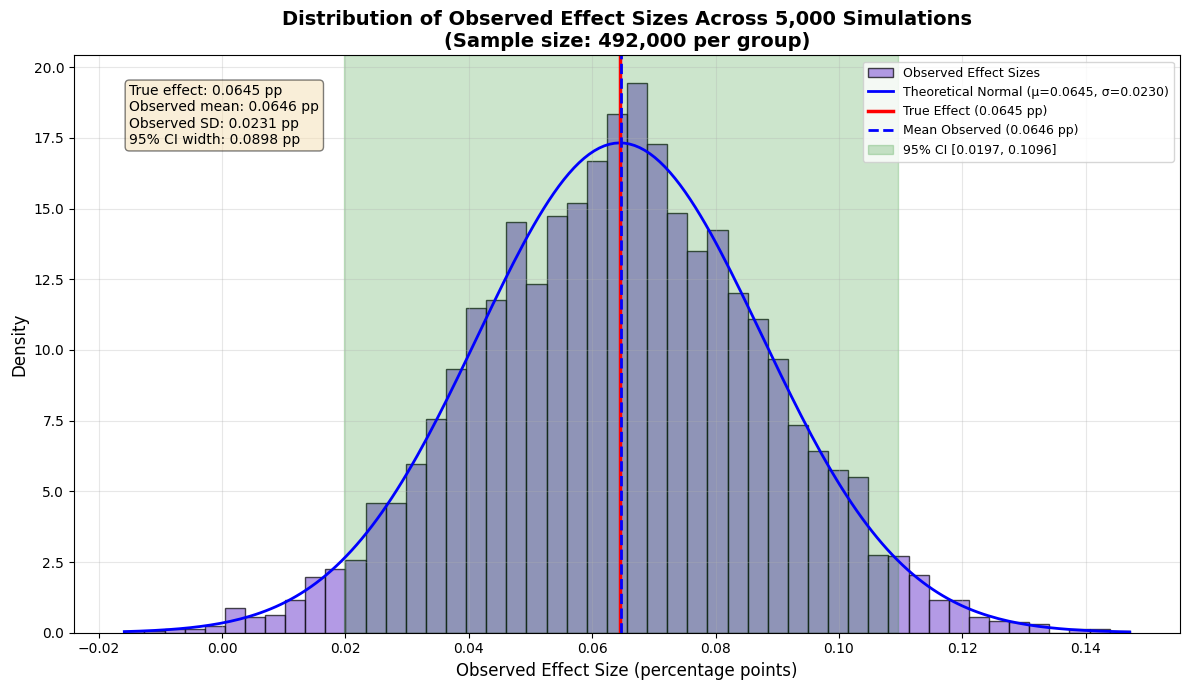


Key Insights:
• Observed effects cluster tightly around true effect (0.0645 pp)
• Standard deviation is small (0.0231 pp) due to large sample size
• 95% of experiments observe effect between 0.0197 and 0.1096 pp
• Even with 492K per group, individual experiments vary by ~±0.0452 pp
• This demonstrates why large samples are crucial for detecting small effects


In [20]:
# Set random seed for reproducibility
np.random.seed(42)

# Run simulations and collect effect sizes
n_fixed = 492000
baseline = 0.0129
treatment = 0.013545
true_effect = treatment - baseline  # 0.000645 or 0.0645 percentage points

print(f"Running simulations to collect effect size distribution...")
print(f"Sample size: {n_fixed:,} per group")
print(f"True effect: {true_effect:.6f} ({true_effect*100:.4f} percentage points)")
print("-" * 60)

results = run_detailed_simulations(
    baseline_rate=baseline,
    treatment_rate=treatment,
    n_per_group=n_fixed,
    n_simulations=5000,
    alpha=0.05,
    under_null=False
)

effect_sizes = results['effect_sizes']

# Calculate statistics
mean_effect = np.mean(effect_sizes)
std_effect = np.std(effect_sizes, ddof=1)
ci_lower = np.percentile(effect_sizes, 2.5)
ci_upper = np.percentile(effect_sizes, 97.5)

print(f"Simulation complete!")
print(f"\nEffect Size Statistics:")
print(f"True effect:      {true_effect:.6f} ({true_effect*100:.4f} pp)")
print(f"Mean observed:    {mean_effect:.6f} ({mean_effect*100:.4f} pp)")
print(f"Std deviation:    {std_effect:.6f} ({std_effect*100:.4f} pp)")
print(f"95% CI:           [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"                  [{ci_lower*100:.4f} pp, {ci_upper*100:.4f} pp]")
print("-" * 60)

# Calculate theoretical standard error
theoretical_se = np.sqrt((baseline*(1-baseline) + treatment*(1-treatment)) / n_fixed)
print(f"\nTheoretical SE:   {theoretical_se:.6f} ({theoretical_se*100:.4f} pp)")
print(f"Observed SE:      {std_effect:.6f} ({std_effect*100:.4f} pp)")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram of observed effect sizes
counts, bins, patches = ax.hist(effect_sizes * 100, bins=50, edgecolor='black', 
                                 alpha=0.7, color='mediumpurple', density=True,
                                 label='Observed Effect Sizes')

# Overlay theoretical normal distribution
x_range = np.linspace(effect_sizes.min()*100, effect_sizes.max()*100, 200)
theoretical_normal = stats.norm.pdf(x_range, loc=true_effect*100, scale=theoretical_se*100)
ax.plot(x_range, theoretical_normal, 'b-', linewidth=2, 
        label=f'Theoretical Normal (μ={true_effect*100:.4f}, σ={theoretical_se*100:.4f})')

# Add vertical lines
ax.axvline(x=true_effect*100, color='red', linestyle='-', linewidth=2.5, 
           label=f'True Effect ({true_effect*100:.4f} pp)')
ax.axvline(x=mean_effect*100, color='blue', linestyle='--', linewidth=2, 
           label=f'Mean Observed ({mean_effect*100:.4f} pp)')

# Add confidence interval shading
ax.axvspan(ci_lower*100, ci_upper*100, alpha=0.2, color='green', 
           label=f'95% CI [{ci_lower*100:.4f}, {ci_upper*100:.4f}]')

# Formatting
ax.set_xlabel('Observed Effect Size (percentage points)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Observed Effect Sizes Across 5,000 Simulations\n(Sample size: 492,000 per group)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Add annotations
ax.text(0.05, 0.95, 
        f'True effect: {true_effect*100:.4f} pp\n'
        f'Observed mean: {mean_effect*100:.4f} pp\n'
        f'Observed SD: {std_effect*100:.4f} pp\n'
        f'95% CI width: {(ci_upper-ci_lower)*100:.4f} pp',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"• Observed effects cluster tightly around true effect ({true_effect*100:.4f} pp)")
print(f"• Standard deviation is small ({std_effect*100:.4f} pp) due to large sample size")
print(f"• 95% of experiments observe effect between {ci_lower*100:.4f} and {ci_upper*100:.4f} pp")
print(f"• Even with 492K per group, individual experiments vary by ~±{1.96*std_effect*100:.4f} pp")
print(f"• This demonstrates why large samples are crucial for detecting small effects")